In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
import langid
from tabulate import tabulate
import langcodes

# Load Dataset

In [3]:
df = pd.read_parquet("../phase1_data_collection/raw datasets/track_raw.parquet")
df.head(5)

,track_idx,track_uri,album_name,album_idx,artist_name,artist_idx,duration_ms,track_name,danceability,energy,...,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,lyrics,track_popularity,release_date
0,0,spotify:track:000DfZJww8KiixTKuk9usJ,The Change I'm Seeking,78824,Mike Love,20091,357573,Earthlings,0.631,0.513,...,0.0293,0.366000,0.000004,0.1090,0.307,120.365,4.0,I just can't take no more\n I gotta get out of...,17.0,2012-12-21
1,1,spotify:track:000GjfnQc7ggBayDiy1sLW,Y las Mariposas,19030,El Poder De Zacatecas,26382,140360,Abeja Miope,0.913,0.748,...,0.0428,0.074500,0.000956,0.0403,0.864,114.143,4.0,None,18.0,2000-06-07
2,2,spotify:track:000JCyEkMFumqCZQJAORiQ,Enough Is Enough,80563,Nipsey Hussle,1633,207124,California Water,0.795,0.874,...,0.2100,0.064600,0.000000,0.3410,0.483,132.966,4.0,None,20.0,2015-09-04
3,3,spotify:track:000VZqvXwT0YNqKk7iG2GS,Dear Youth,118169,The Ghost Inside,47069,256478,Mercy,0.444,0.991,...,0.1330,0.000085,0.000084,0.1200,0.106,124.016,4.0,For whom the bell tolls\n There's a hurricane ...,41.0,2014-11-17
4,4,spotify:track:000uWezkHfg6DbUPf2eDFO,Dancehall Days,55985,The Beautiful Girls,4863,321679,Me I Disconnect From You,0.714,0.635,...,0.0299,0.001940,0.259000,0.0839,0.360,134.007,4.0,None,5.0,2014-10-03


# Check Data Types

In [4]:
print(df.dtypes)

track_idx             int64
track_uri            object
album_name           object
album_idx             int64
artist_name          object
artist_idx            int64
duration_ms           int64
track_name           object
danceability        float64
energy              float64
key                 float64
loudness            float64
mode                float64
speechiness         float64
acousticness        float64
instrumentalness    float64
liveness            float64
valence             float64
tempo               float64
time_signature      float64
lyrics               object
track_popularity    float64
release_date         object
dtype: object


# Statistical Summary of Numerical Columns

In [5]:
print(df.describe())

           track_idx      album_idx     artist_idx   duration_ms  \
count  252236.000000  252236.000000  252236.000000  2.522360e+05   
mean   126117.500000   64960.924479   27115.928230  2.377764e+05   
std     72814.405587   37490.235271   15784.973095  9.681974e+04   
min         0.000000       0.000000       0.000000  2.454000e+03   
25%     63058.750000   32632.000000   13564.000000  1.920000e+05   
50%    126117.500000   64977.500000   26854.000000  2.236030e+05   
75%    189176.250000   97402.250000   40987.000000  2.647060e+05   
max    252235.000000  129877.000000   54455.000000  7.575928e+06   

        danceability         energy            key       loudness  \
count  252209.000000  252209.000000  252209.000000  252209.000000   
mean        0.579452       0.622506       5.278563      -8.141255   
std         0.170929       0.234978       3.581118       4.427018   
min         0.000000       0.000000       0.000000     -60.000000   
25%         0.468000       0.466000       

# Check Null Values in each column

In [6]:
print(df.isnull().sum())  

track_idx                0
track_uri                0
album_name               0
album_idx                0
artist_name              0
artist_idx               0
duration_ms              0
track_name               1
danceability            27
energy                  27
key                     27
loudness                27
mode                    27
speechiness             27
acousticness            27
instrumentalness        27
liveness                27
valence                 27
tempo                   27
time_signature          27
lyrics               65006
track_popularity    112417
release_date           371
dtype: int64


# Handling Missing Values (Part 1)

### `track_name`

Only had 1 missing track_name, so we went to manually search on the track name using the track_uri provided

In [7]:
df.loc[df['track_name'].isnull(), 'track_name'] = 'None'

# Convert Units

`duration_ms` is the duration of each track. The units are currently in terms of milliseconds, and for better representation, we would be converting it to seconds, and rounding it to the nearest seconds.

In [8]:
df['duration'] = df['duration_ms'] // 1000
df = df.drop(columns=['duration_ms']) 

`release_date` is the album release date for the track. The units are mostly in YYYY-MM-DD and we would be converting it to years.

In [9]:
df["release_year"] = df["release_date"].apply(lambda x: str(x)[:4] if pd.notna(x) else None)
df["release_year"] = pd.to_numeric(df["release_year"], errors="coerce").astype("Int64")
df = df.drop(columns=['release_date']) 

# Handling Missing Values (Part 2)

### `release_year`

There are 371 missing release_year

First, impute by using the year of other tracks in the same album

In [10]:
missing_before = df['release_year'].isna().sum()

df['release_year'] = df.apply(
    lambda row: row['release_year'] if pd.notna(row['release_year']) else 
                df.loc[df['album_idx'] == row['album_idx'], 'release_year'].dropna().iloc[0] 
                if not df.loc[df['album_idx'] == row['album_idx'], 'release_year'].dropna().empty else pd.NA, 
    axis=1
).astype("Int64")

num_imputed = missing_before - df['release_year'].isna().sum()
total_imputed = num_imputed
print(f"Imputed {num_imputed} missing values ({num_imputed / missing_before * 100:.2f}%).")

Imputed 5 missing values (1.35%).


Next, impute by using the median year of other tracks by the same artist

In [11]:
df['release_year'] = df.apply(
    lambda row: row['release_year'] if pd.notna(row['release_year']) else 
                int(df[df['artist_idx'] == row['artist_idx']]['release_year'].dropna().median()) 
                if not df[df['artist_idx'] == row['artist_idx']]['release_year'].dropna().empty else pd.NA,
    axis=1
).astype("Int64")

num_imputed = missing_before - df['release_year'].isna().sum() - total_imputed 
total_imputed += num_imputed
print(f"Imputed {num_imputed} missing values ({num_imputed / missing_before * 100:.2f}%).")

Imputed 170 missing values (45.82%).


Lastly, impute by taking the median year of all other tracks

In [12]:
global_median = int(df['release_year'].dropna().median())  
df['release_year'] = df['release_year'].fillna(global_median)  

num_imputed = missing_before - df['release_year'].isna().sum() - total_imputed 
total_imputed += num_imputed
print(f"Imputed {num_imputed} missing values ({num_imputed / missing_before * 100:.2f}%).")

Imputed 196 missing values (52.83%).


# Categorization of Columns

### `release_year`

For tracks released earlier than 1960, we will classify it as 'Early Years'. <br> <br>
For tracks released between 1960 and 1980, we will classify it as 'Classic Era'. <br> <br>
For tracks released between 1980 and 2000, we will classify it as 'Golden Era'. <br> <br>
For tracks released between 2000 and 2010, we will classify it as '2010s'. <br> <br>
For tracks released after 2010, we will classify it as 'Modern Era'. <br> <br>

In [13]:
def categorize_era(year):
    if year < 1960:
        return "Early Years"
    elif 1960 <= year < 1980:
        return "Classic Era"
    elif 1980 <= year < 2000:
        return "Golden Era"
    elif 2000 <= year < 2010:
        return "2000s"
    else:
        return "Modern Era"

df["era"] = df["release_year"].apply(categorize_era)

### `duration`

For tracks shorter than 180 seconds (3 min), we will classify it as short. <br> <br>
For tracks between 180 seconds (3 min) and 240 seconds (4 min), we will classify it as medium. <br> <br>
For tracks longer than 240 seconds (4 min), we will classify it as short.

In [14]:
def categorize_duration(duration):
    if duration < 180:
        return "Short"
    elif 180 <= duration < 240:
        return "Medium"
    else:
        return "Long"

df['category'] = df['duration'].apply(categorize_duration)

# Check Distribution for Columns & Outliers

### Identify Columns that are Numerical & Categorical

In [15]:
numerical_col = ['track_popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
categorical_col = ['time_signature', 'key', 'mode', 'era', 'category']

### Histogram for Continuous Variables

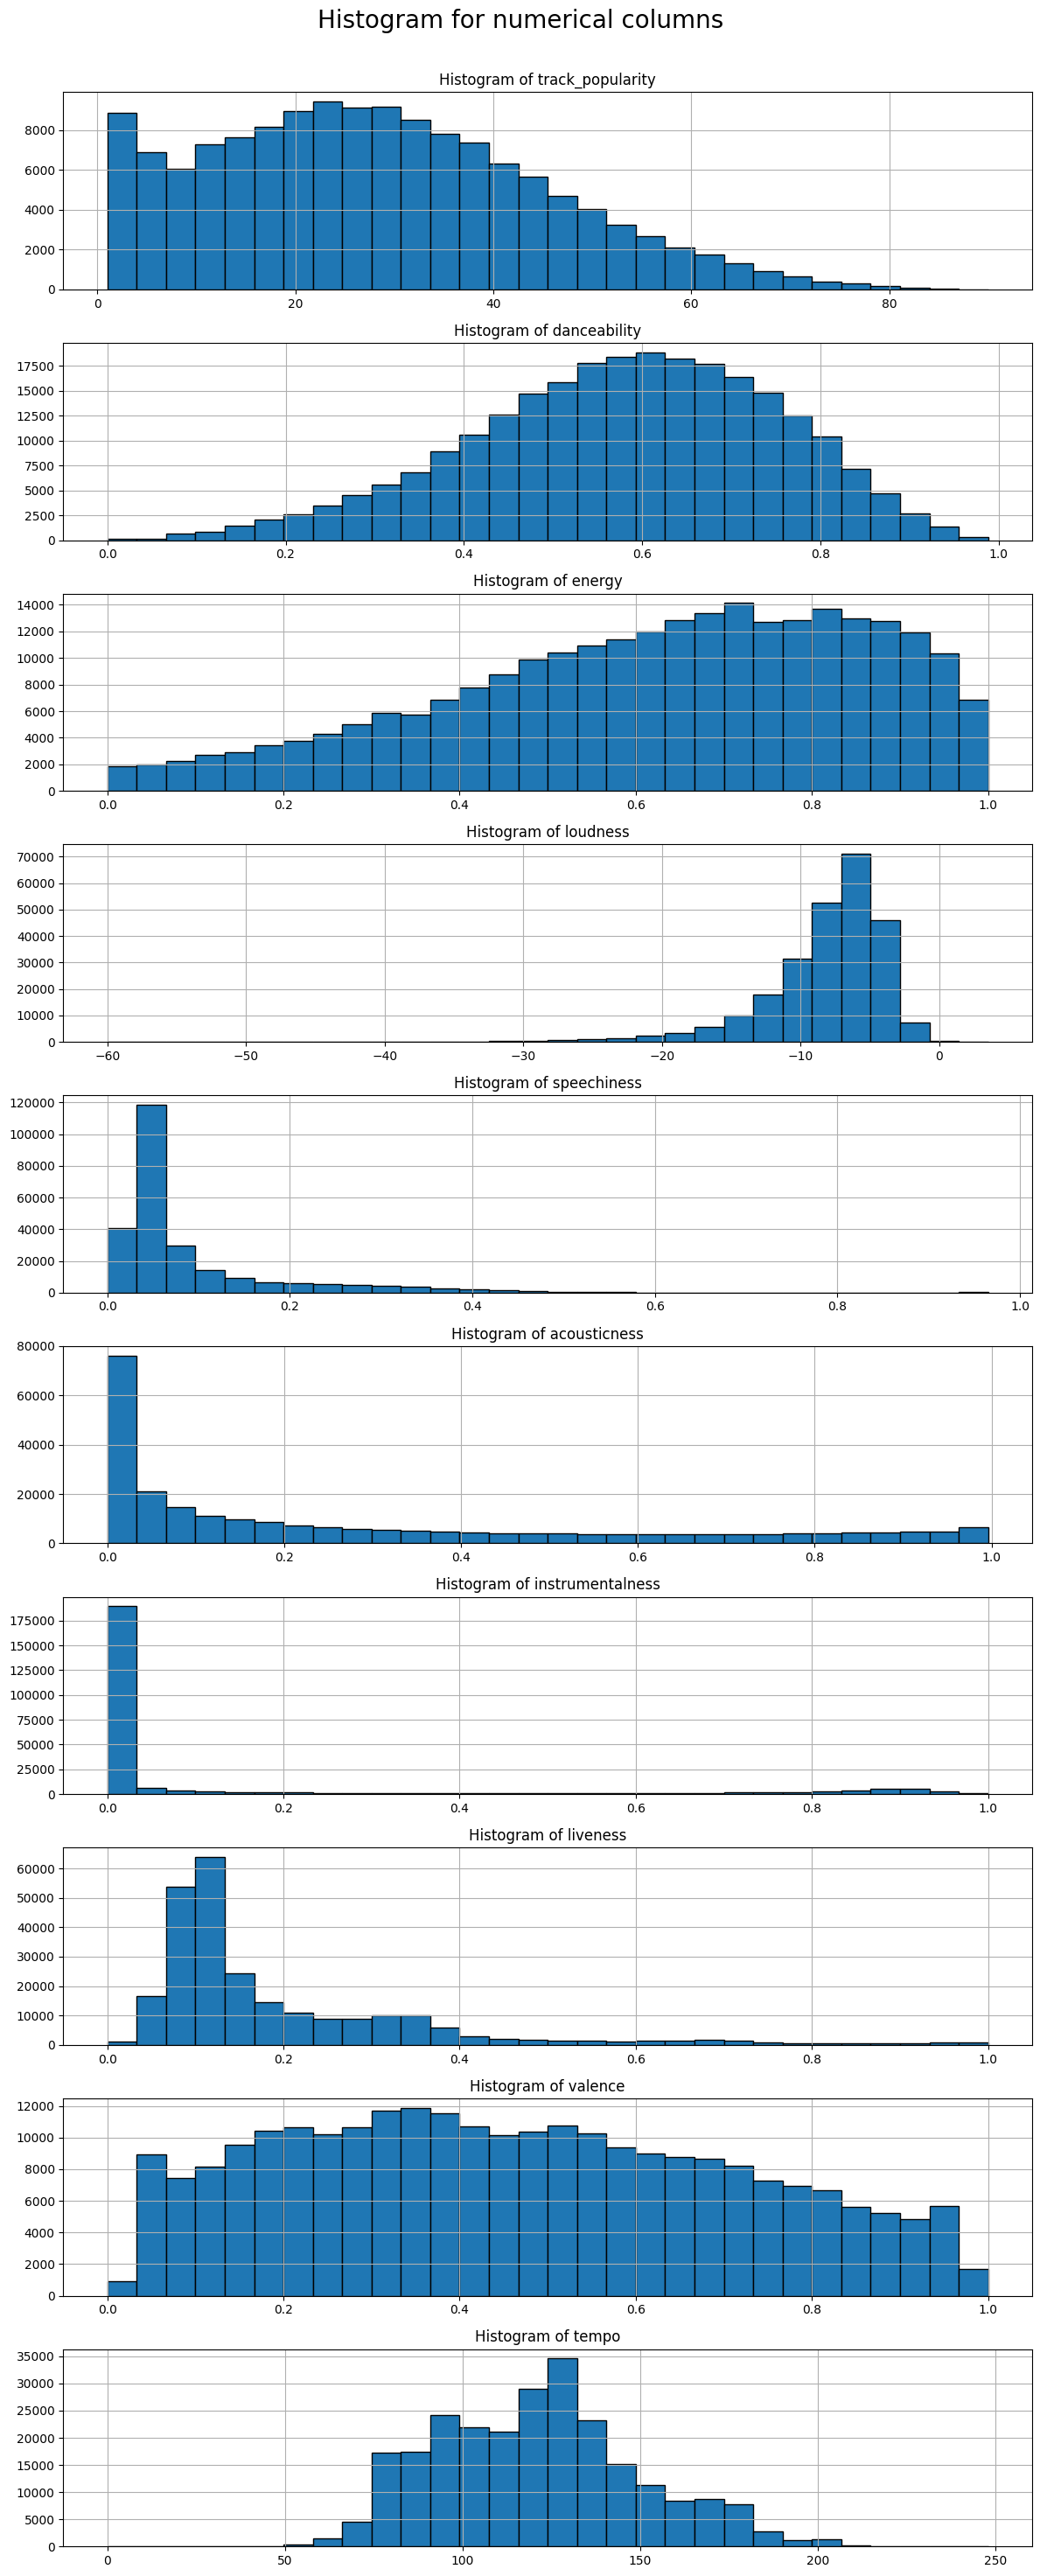

In [16]:
num_cols = df[numerical_col]

plt.figure(figsize=(12, len(num_cols.columns) * 3))

for i, col in enumerate(num_cols.columns, 1):
    plt.subplot(len(num_cols.columns), 1, i)  
    df[col].hist(bins=30, edgecolor='black')  
    plt.title(f'Histogram of {col}')  

plt.suptitle("Histogram for numerical columns", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.975])
plt.show()

### Barplots for Categorical Variables

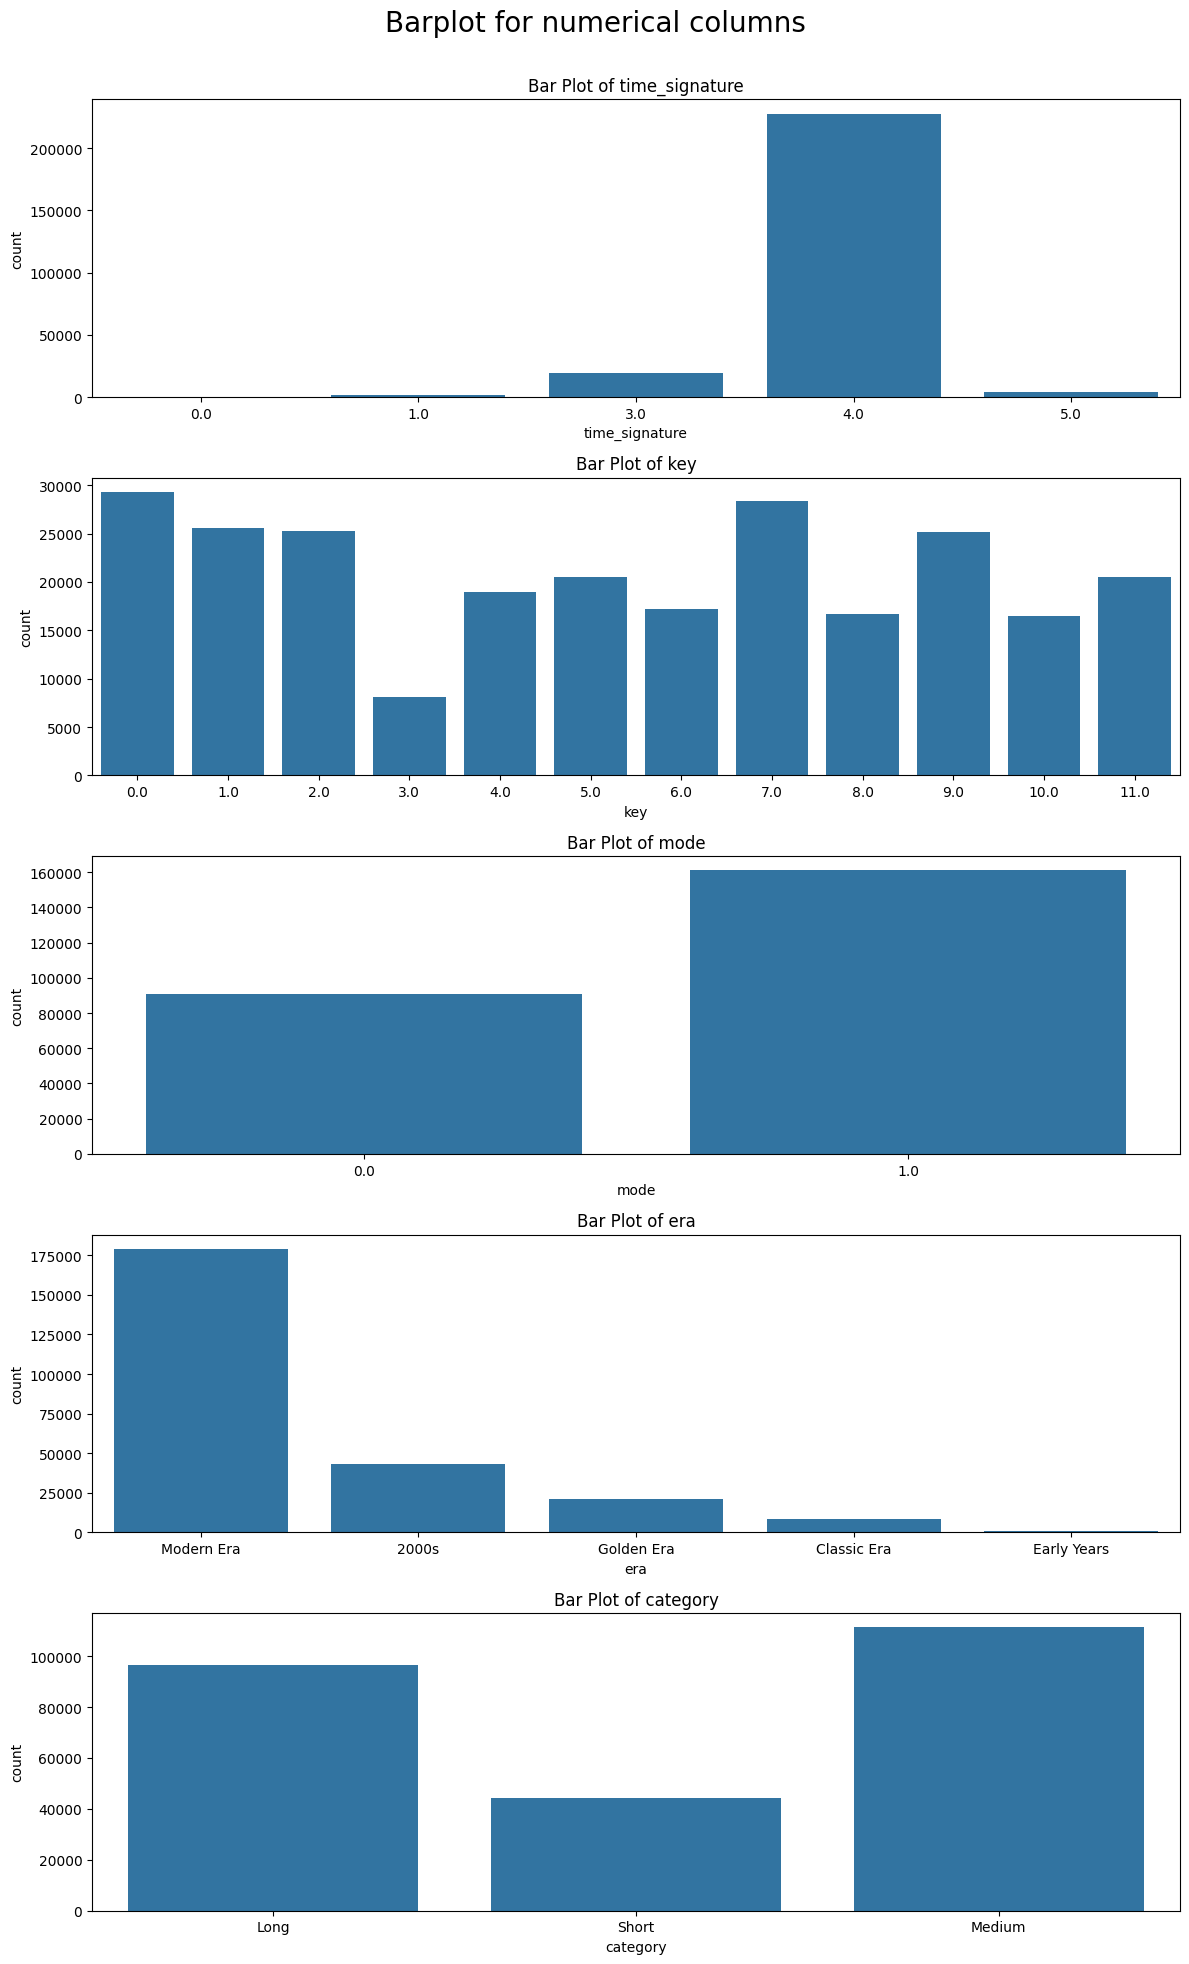

In [17]:
plt.figure(figsize=(12, len(categorical_col) * 4))

for i, col in enumerate(categorical_col, 1):
    plt.subplot(len(categorical_col), 1, i) 
    sns.countplot(data=df, x=col)  
    plt.title(f'Bar Plot of {col}')

plt.suptitle("Barplot for numerical columns", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.975])
plt.show()

### Boxplots for Numerical

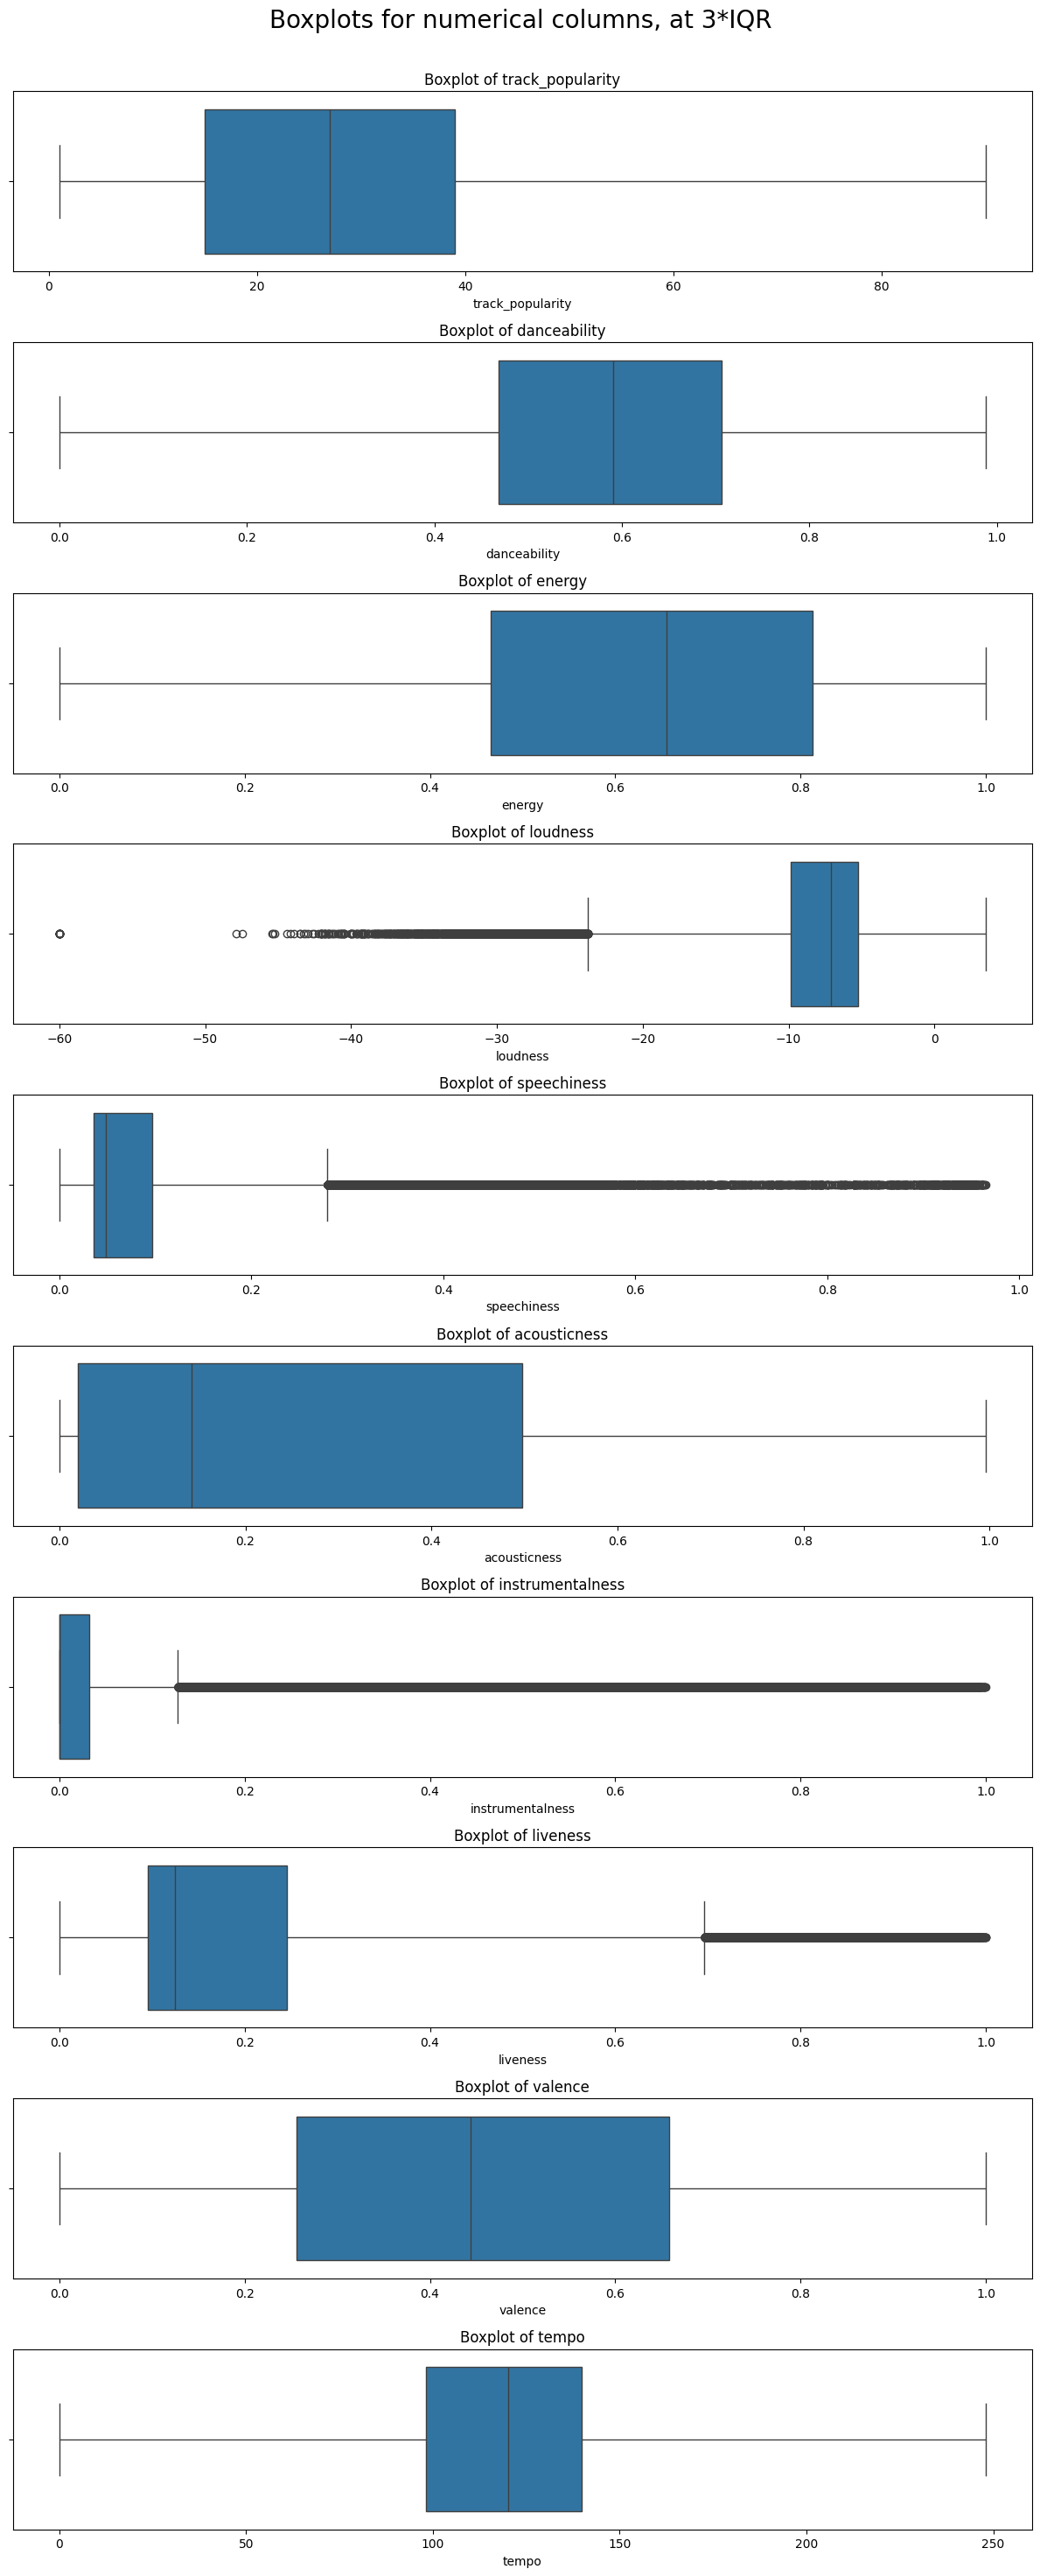

In [18]:
plt.figure(figsize=(12, len(num_cols.columns) * 3))

for i, col in enumerate(num_cols.columns, 1):
    plt.subplot(len(num_cols.columns), 1, i)  
    sns.boxplot(x=num_cols[col], whis=3)  
    plt.title(f'Boxplot of {col}')  

plt.suptitle("Boxplots for numerical columns, at 3*IQR", fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.975])
plt.show()

As seen from the visualizations, there are data points that lies outside the 3*IQR. 

However, there is a large number of "outliers", and these are likely due to systematic reasons of the musical attributes of the tracks. These "outliers" are likely due to the inherent characteristics of the tracks. Furthermore, each track is unique, and extreme values in attributes like loudness or energy can represent intentional artistic choices rather than errors.

As such, we are not going to handle these outliers, as they reflect genuine data points that are important for understanding the diversity of musical tracks

# Handling Missing Values (Part 3)

### `track_popularity`

There are 112,417 missing track_popularity

Firstly, impute by taking the average popularity of the other tracks in the same playlist

In [19]:
missing_before = df['track_popularity'].isna().sum()

album_popularity_mean = df.groupby('album_idx')['track_popularity'].transform(lambda x: round(x.mean()) if not x.isna().all() else np.nan)

df['track_popularity_impute'] = df['track_popularity'].fillna(album_popularity_mean)

num_imputed = missing_before - df['track_popularity_impute'].isna().sum()
total_imputed = num_imputed
print(f"Imputed {num_imputed} missing values ({num_imputed / missing_before * 100:.2f}%).")

Imputed 4847 missing values (4.31%).


Next, impute by taking the popularity of the other tracks by the same artist. For every artist, we will form a range of values, and impute the poularity scores randomly, so that the distribution is not affected.

In [20]:
# Set random seed for reproducibility
np.random.seed(42)

# Calculate min and max popularity by artist, ensuring no NaN or empty values
artist_pop_range = df.groupby('artist_idx')['track_popularity_impute'].agg(['min', 'max'])

# Add check for NaN or invalid ranges
artist_pop_range = artist_pop_range.dropna()  # Drop any NaN values in the range

# Impute missing popularity values by sampling within the artist's popularity range
df['track_popularity_impute'] = df.apply(
    lambda row: round(np.random.uniform(artist_pop_range.loc[row['artist_idx'], 'min'], 
                                 artist_pop_range.loc[row['artist_idx'], 'max'])) 
    if pd.isna(row['track_popularity_impute']) and row['artist_idx'] in artist_pop_range.index else row['track_popularity_impute'], 
    axis=1)

num_imputed = missing_before - df['track_popularity_impute'].isna().sum() - total_imputed 
total_imputed += num_imputed
print(f"Imputed {num_imputed} missing values ({num_imputed / missing_before * 100:.2f}%).")

Imputed 56231 missing values (50.02%).


Next, impute by taking the popularity of the other tracks released in the same year. Likewise for what has been for aritsts, for each year, we will form a range of values, and impute the poularity scores randomly, so that the distribution is not affected

In [21]:
# Set random seed for reproducibility
np.random.seed(42)

# Ensure the min/max is calculated properly by year and dropped NaNs
year_pop_range = df.groupby('release_year')['track_popularity_impute'].agg(['min', 'max'])

# Drop any rows with NaN values in min or max
year_pop_range = year_pop_range.dropna()

# Impute missing popularity values by sampling within the release year's popularity range
df['track_popularity_impute'] = df.apply(
    lambda row: (
        year_pop_range.loc[row['release_year'], 'min']  # If only one value exists for the year
        if year_pop_range.loc[row['release_year'], 'min'] == year_pop_range.loc[row['release_year'], 'max'] 
        else round(np.random.uniform(year_pop_range.loc[row['release_year'], 'min'], 
                               year_pop_range.loc[row['release_year'], 'max'])) # Otherwise sample within range
    ) if pd.isna(row['track_popularity_impute']) and row['release_year'] in year_pop_range.index 
    else row['track_popularity_impute'], 
    axis=1
)

# df['track_popularity_impute'] = df.apply(
#     lambda row: np.random.uniform(artist_pop_range.loc[row['release_year'], 'min'], 
#                                  artist_pop_range.loc[row['release_year'], 'max']) 
#     if pd.isna(row['track_popularity_impute']) and row['artist_idx'] in artist_pop_range.index else row['track_popularity_impute'], 
#     axis=1)

num_imputed = missing_before - df['track_popularity_impute'].isna().sum() - total_imputed 
total_imputed += num_imputed
print(f"Imputed {num_imputed} missing values ({num_imputed / missing_before * 100:.2f}%).")

Imputed 51335 missing values (45.66%).


Finally, impute by taking the average popularity of all tracks

In [22]:
global_mean_popularity = round(df['track_popularity_impute'].mean() )
df['track_popularity_impute'] = df['track_popularity_impute'].fillna(global_mean_popularity)  

df['track_popularity_impute'] = df['track_popularity_impute'].astype(int)

num_imputed = missing_before - df['track_popularity_impute'].isna().sum() - total_imputed 
total_imputed += num_imputed
print(f"Imputed {num_imputed} missing values ({num_imputed / missing_before * 100:.2f}%).")

Imputed 4 missing values (0.00%).


Comparing the distribution before and after imputation

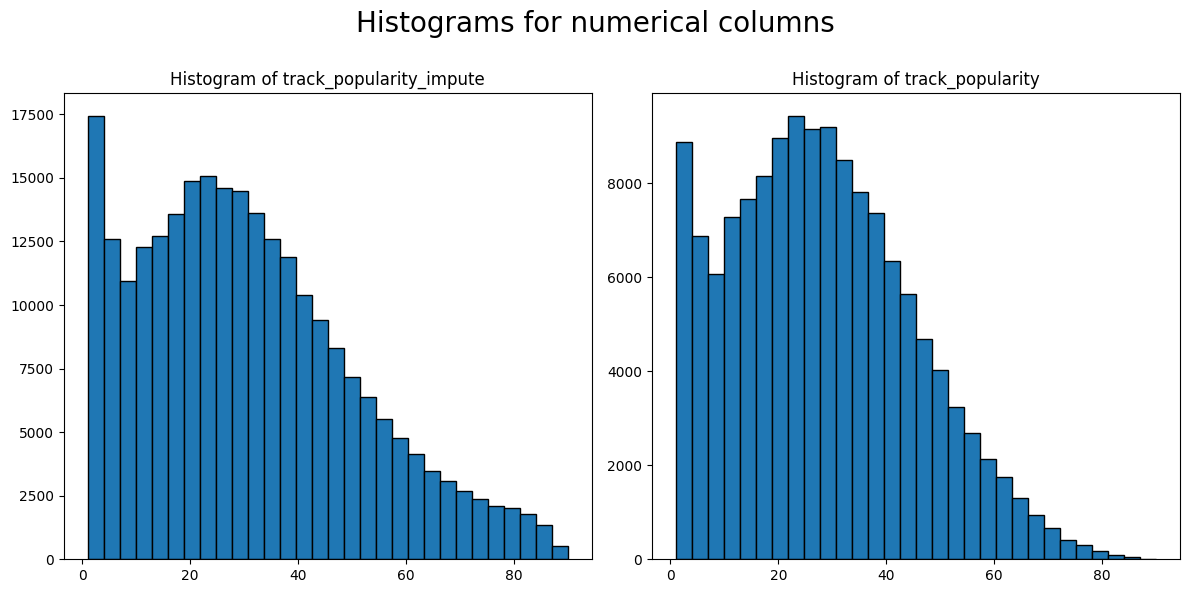

In [23]:
# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Plot the first histogram
axes[0].hist(df['track_popularity_impute'], bins=30, edgecolor='black')
axes[0].set_title('Histogram of track_popularity_impute')

# Plot the second histogram (you can change it to any other column or data you want)
axes[1].hist(df['track_popularity'], bins=30, edgecolor='black')
axes[1].set_title('Histogram of track_popularity')

# Set a suptitle for the overall figure
plt.suptitle("Histograms for numerical columns", fontsize=20)

# Adjust layout
plt.tight_layout(rect=[0, 0, 1, 0.975])

# Show the plot
plt.show()

The distribution is more or less similar, with slightly higher frequency for the low popularity. This is fair as the tracks that do not have a valid popularity score are likely due to systematic reasons.

### Audio Features

As seen previously in 'Handling Missing Values (Part 1)', there are 27 tracks with missing audio features, out of 252,236 tracks. This is a very small proportion of missing data.

As seen in the data visualization for the audio features: 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'key', 'mode', the distribution is not symmetrical. 

As such, we would replace missing values with the median instead.

In [24]:
numerical_audio_cols = ['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']
categorical_audio_cols = ['time_signature', 'key', 'mode']

numerical_imputer = SimpleImputer(strategy='median')
categorical_imputer = SimpleImputer(strategy='most_frequent')

df[numerical_audio_cols] = numerical_imputer.fit_transform(df[numerical_audio_cols])

df[categorical_audio_cols] = categorical_imputer.fit_transform(df[categorical_audio_cols])

### Progress of Data Cleaning

In [25]:
df = df.drop(columns=['track_popularity']) 
print(df.isnull().sum())  

track_idx                      0
track_uri                      0
album_name                     0
album_idx                      0
artist_name                    0
artist_idx                     0
track_name                     0
danceability                   0
energy                         0
key                            0
loudness                       0
mode                           0
speechiness                    0
acousticness                   0
instrumentalness               0
liveness                       0
valence                        0
tempo                          0
time_signature                 0
lyrics                     65006
duration                       0
release_year                   0
era                            0
category                       0
track_popularity_impute        0
dtype: int64


We are only left with missing data in `lyrics` to handle.

# Lyrics Data Cleaning

When extracting lyrics from various datasets, some tracks were filled up as [Instrumental], [No Lyrics], or for classicals, it was filled up with a numerical value and some tracks also had lyrics in foreign languages such as Korean, Mandarin, Russian, etc.

We are first going to identify the tracks with lyrics as [Instrumental], [No Lyrics].

In [26]:
instrumental_rows = df[df['lyrics'] == '[Instrumental]']
print("Number of songs with lyrics filled as '[Instrumental]':", len(instrumental_rows))

no_lyrics_rows = df[df['lyrics'] == '[No Lyrics]']
print("Number of songs with lyrics filled as '[No Lyrics]':", len(no_lyrics_rows))

Number of songs with lyrics filled as '[Instrumental]': 10137
Number of songs with lyrics filled as '[No Lyrics]': 15


Next, we are first going to identify the tracks with lyrics as a number.

In [27]:
numeric_lyrics = df[df['lyrics'].str.match(r'^-?\d+$', na=False)]
print("Number of songs with lyrics filled as a number:", len(numeric_lyrics))

Number of songs with lyrics filled as a number: 1198


However, these songs having placeholders for lyrics is important, as these songs itself does not have lyrics. As such, we will be using another placeholder, 'No Lyrics'

In [28]:
df['lyrics'] = df['lyrics'].replace('[Instrumental]', np.nan)
df['lyrics'] = df['lyrics'].replace('[No Lyrics]', np.nan)
df['lyrics'] = df['lyrics'].replace(r'^-?\d+$', np.nan, regex=True)

Some lyrics contain [Intro], [Chorus], [Verse 1] in the lyrics, and we will use regular expression to remove these.

In [29]:
df['lyrics'] = df['lyrics'].replace(r'[\[\(].*?[\]\)]', '', regex=True)

### Detecting Languages of Lyrics

There are many tracks with lyrics in foreign languages, and we will classify how many tracks there are per each language, using the library `langid`

In [30]:
valid_lyrics_mask = df['lyrics'].notna()

lyrics_snippets = df.loc[valid_lyrics_mask, 'lyrics'].str.split(n=10).str[:10].str.join(' ')

lyrics_languages = lyrics_snippets.map(lambda text: langid.classify(text)[0])

language_counts = lyrics_languages.value_counts()

print(language_counts)

lyrics
en    154538
es      8068
fr      1340
ko      1130
pt      1029
       ...  
ps         2
hy         1
mn         1
kk         1
ky         1
Name: count, Length: 87, dtype: int64


Presenting the counts in a Table with Proportions after mapping the language codes

In [31]:
def get_language_name(lang_code):
    try:
        language = langcodes.Language.get(lang_code)
        return language.display_name()
    except:
        return lang_code  

top_20_languages = language_counts.nlargest(20)
top_20_df = top_20_languages.reset_index()
top_20_df.columns = ['Language', 'Count']

total_count = top_20_df['Count'].sum()
top_20_df['Proportion (%)'] = round((top_20_df['Count'] / total_count) * 100, 2)

top_20_df['Language'] = top_20_df['Language'].apply(get_language_name)

print("Top 20 Languages with the Most Instances in Lyrics")
print(tabulate(top_20_df, headers='keys', tablefmt='pretty', showindex=False))

Top 20 Languages with the Most Instances in Lyrics
+------------+--------+----------------+
|  Language  | Count  | Proportion (%) |
+------------+--------+----------------+
|  English   | 154538 |     89.74      |
|  Spanish   |  8068  |      4.69      |
|   French   |  1340  |      0.78      |
|   Korean   |  1130  |      0.66      |
| Portuguese |  1029  |      0.6       |
|   German   |  820   |      0.48      |
| Indonesian |  694   |      0.4       |
|  Italian   |  685   |      0.4       |
|  Filipino  |  556   |      0.32      |
|   Dutch    |  441   |      0.26      |
|   Malay    |  432   |      0.25      |
|  Swahili   |  350   |      0.2       |
|  Finnish   |  325   |      0.19      |
|  Chinese   |  318   |      0.18      |
|  Galician  |  266   |      0.15      |
|  Catalan   |  255   |      0.15      |
| Afrikaans  |  251   |      0.15      |
|  Swedish   |  236   |      0.14      |
|   Welsh    |  235   |      0.14      |
|   Polish   |  228   |      0.13      |
+-----

As expected, most of the songs are in English, followed by Spanish which is the second highest.

As we would be doing sentiment analysis on the lyrics, it is important to ensure that the languages of the lyrics are accounted for. We would thus be using multilingual sentiment models, to prevent having to translate using APIs.

# Handling Missing Values (Part 4)

In [32]:
missing = df['lyrics'].isna().sum()
print(f"Number of missing values: {missing}")

Number of missing values: 76356


Currently, there are 76,356 tracks with unavailable lyrics, either due to the song itself not having any lyrics in the music, or due to unavailable data.

In [33]:
percentage_missing = (missing / len(df)) * 100
print(f"Percentage of missing values: {percentage_missing:.2f}%")

Percentage of missing values: 30.27%


It accounts to about 30% missing data, and we will handle these missing data after we conduct sentiment analysis. We will use imputation methods, such as filling it up by the average sentiment of other songs by the same artist, or just giving a neutral sentiment score.

# Save Dataset

In [34]:
df_sorted = df.sort_values(by='track_idx', ascending=True)
df_sorted = df_sorted.rename(columns={'track_popularity_impute': 'track_popularity'})
df_sorted.to_parquet('../phase2_data_cleaning/cleaned dataset/track_cleaned.parquet') 